Investigate the glacier-scale and regional-scale trend in water area over time

In [16]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from sklearn import linear_model
from sklearn.feature_selection import f_regression
import cartopy.crs as ccrs
import cartopy as ctp
import matplotlib.ticker as mticker

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
folder_plotting = os.path.join(folder_HMA, 'Plotting')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [4]:
# matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [5]:
# open data so we can make maps if we want
# opening a Natural Earth background
path_background = os.path.join(folder_plotting, 'NE1_HR_LC', "NE1_HR_LC_shean_aee.tif")
background_im = riox.open_rasterio(path_background)

# clip to main extent
xlims_main = (-1700000,2000000)
ylims_main = (-1100000,1000000)
background_im = background_im.sel(x=slice(xlims_main[0]-2000,xlims_main[1]+2000),
                                  y=slice(ylims_main[1]+2000, ylims_main[0]-2000))

# open the subregion df
path_o1 = os.path.join(folder_HMA, 'Datasets', "RGI", "RGI2000-v7.0-regions", "RGI2000-v7.0-o1regions.shp")
path_o2 = os.path.join(folder_HMA, 'Datasets', "RGI", "RGI2000-v7.0-regions", "RGI2000-v7.0-o2regions.shp")
o1_gdf = gpd.read_file(path_o1).to_crs("ESRI:102025")
o2_gdf_all = gpd.read_file(path_o2).to_crs("ESRI:102025")

# subset to the HMA regions
o1_gdf = o1_gdf[o1_gdf['o1region'].isin(["13","14","15"])]
o2_gdf = o2_gdf_all[o2_gdf_all['o2region'].isin(rgi_gdf['o2region'])].copy() # only get o2regions with our glaciers

# add color column to o2_gdf, based on o1region
colors = []
for idx,row in o2_gdf.iterrows():
    if row['o1region']=='13': colors.append('tab:green')
    elif row['o1region']=='14': colors.append('blue')
    elif row['o1region']=='15': colors.append('tab:red')
o2_gdf['colors']=colors

# define hma-specific alber equal area (from david shean)
projection_shean = ccrs.AlbersEqualArea(central_longitude=85.0, central_latitude=36,
                            false_easting=0.0, false_northing=0.0,
                            standard_parallels=(25.0, 47.0), globe=None)

# define esri:102025 projection for cartopy
projection_esri = ccrs.AlbersEqualArea(central_longitude=95.0, central_latitude=30,
                            false_easting=0.0, false_northing=0.0,
                            standard_parallels=(15.0, 65.0), globe=None)

# other matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [6]:
# open the water data for each glacier, format into a single df
c=0
all_series = []
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>10: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    o3region = row['o3region']
    
    # if o1region!='15':continue
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific cloud info as a pd.Series, append to list   
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'annual_water_area_binary_otsuoptimal_188_binned_accaqa.csv')
    
    df_g = pd.read_csv(path_open, index_col=0, header=None).squeeze()
    df_g['o3_region'] = str(o3region).zfill(2)
    all_series.append(df_g)

# format into df
df_all = pd.DataFrame(all_series).reset_index(drop=True)

# format to numeric dtypes
all_cols = df_all.columns
for c in all_cols:
    if c in ['rgi_id', 'o1_region', 'o2_region', 'o3_region']: continue
    df_all[c] = df_all[c].astype(float)

# add extra columns on for each glacier (dc area, etc...)
df_all = df_all.merge(dc_gdf[['rgi_id','area_dc']], on='rgi_id')

# merge with glacier area
print("All done!")

df_big = df_all[df_all['area_dc']>5]

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-71307
300 of 769 RGI2000-v7.0-G-14-15108
400 of 769 RGI2000-v7.0-G-14-32564
500 of 769 RGI2000-v7.0-G-15-01330
600 of 769 RGI2000-v7.0-G-15-05352
700 of 769 RGI2000-v7.0-G-15-08609
All done!


In [7]:
# load in the list of lake-terminating glaciers, so we can remove those if we want
path_open = os.path.join(folder_datasets, 'lake-terminating glaciers', 'rgi_lake_terminating.csv')
df_lake_term = pd.read_csv(path_open)
rgi_lake_term = df_lake_term['rgi_id'].values

# create subsets of lake terminating vs non-lake terminating so we can compare
df_all_lt = df_all[df_all['rgi_id'].isin(rgi_lake_term)]
df_all_nlt = df_all[~df_all['rgi_id'].isin(rgi_lake_term)]

# select which df to use from here
df_to_use = df_all_nlt #df_all df_all_nlt

In [8]:
# define annual columns, 5-year columns
# intervals = [ [1990,1994],[1995,1999],[2000,2004],[2005,2009],[2010,2014],[2015,2019],[2020,2023] ]
ys = [1988,1990,1992,1994,1996,1998,2000,2002,2004] + list(range(2005,2024))
c_1yr = [ f"water_{y}_m2" for y in ys ]

In [9]:
# subset to only the 2004-2023 time period
c_0423 = ['rgi_id','o1_region','o2_region','area_dc'] + [ f"water_{y}_m2" for y in range(2004,2024) ]
c_0423_term = ['rgi_id','o1_region','o2_region','area_dc'] + [ f"water_{y}_terminus_m2" for y in range(2004,2024) ]
c_1423_term = ['rgi_id','o1_region','o2_region','area_dc'] + [ f"water_{y}_terminus_m2" for y in range(2014,2024) ]

df_0423_full = df_all_nlt[c_0423].rename( 
                    dict(zip([ f"water_{y}_m2" for y in range(2004,2024) ], list(range(2004,2024))  )), axis=1 )
df_0423_term = df_all_nlt[c_0423_term].rename( 
                    dict(zip([ f"water_{y}_terminus_m2" for y in range(2004,2024) ], list(range(2004,2024))  )), axis=1 )
df_1423_term = df_all_nlt[c_1423_term].rename( 
                    dict(zip([ f"water_{y}_terminus_m2" for y in range(2014,2024) ], list(range(2014,2024))  )), axis=1 )

In [10]:
# define a function to use simple linear regression on a list of years and areas
def regress_glacier(years, areas):
    
    # make into df quickly
    df_reg = pd.DataFrame({"x":years, "y":areas })

    # calculate regression
    X = df_reg[['x']]
    y = df_reg['y']
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(X.values, y.values)

    # get regression values
    slope = regr.coef_[0]
    r2 = regr.score(X.values,y.values)

    # get p-values
    freg=f_regression(X.values.reshape(-1, 1),np.array(y.values))
    p=freg[1][0].round(5)
    
    # get start/end points so line can be plotted
    mm = np.array([np.nanmin(years), np.nanmax(years)]).reshape(-1,1)
    
    # return data
    return(p, round(slope,5), round(r2,5), list(mm.reshape(1,-1)[0]), list(regr.predict(mm)) )
    
def get_glacier_rgi(rgi_id, glacier_name):
    
    # get the rgi_id if glacier name was provided
    if glacier_name:
        rgi_id = rgi_gdf[rgi_gdf['glac_name'].str.contains(glacier_name)==True]['rgi_id'].values[0]
    
    return rgi_id

In [11]:
# calculate the slope and significance of the 2004-2023 water timeseries for every glacier
years_to_use = list(range(2004,2024))

# for terminus areas of all glaciers
regression_df_terminus_0423 = []
for idx, row in df_0423_term.iterrows():
    # get the data for this row
    areas_to_use = list(row[years_to_use].values)

    p_g, slope_g, r2_g, xs_g, ys_g = regress_glacier(years_to_use, areas_to_use)
    out_df = pd.DataFrame({'rgi_id':[row['rgi_id']], 'o1_region':[row['o1_region']], 'o2_region':[row['o2_region']],
                          'slope':[slope_g], 'p':[p_g], 'r2':[r2_g], 'xs':[xs_g], 'ys':[ys_g],
                           'median':[np.nanmedian(areas_to_use)], 'mean':[np.nanmean(areas_to_use)],
                           'area_dc':[row['area_dc']]})
    regression_df_terminus_0423.append(out_df)
regression_df_terminus_0423 = pd.concat(regression_df_terminus_0423)

# for full glacier extent
regression_df_full = []
for idx, row in df_0423_full.iterrows():
    # get the data for this row
    areas_to_use = list(row[years_to_use].values)

    p_g, slope_g, r2_g, xs_g, ys_g = regress_glacier(years_to_use, areas_to_use)
    out_df = pd.DataFrame({'rgi_id':[row['rgi_id']], 'o1_region':[row['o1_region']], 'o2_region':[row['o2_region']],
                          'slope':[slope_g], 'p':[p_g], 'r2':[r2_g], 'xs':[xs_g], 'ys':[ys_g],
                           'median':[np.nanmedian(areas_to_use)], 'mean':[np.nanmean(areas_to_use)],
                           'area_dc':[row['area_dc']]})
    regression_df_full.append(out_df)
regression_df_full = pd.concat(regression_df_full)

### repeat for terminus 2014-2023
years_to_use = list(range(2014,2024))
regression_df_terminus_1423 = []
for idx, row in df_1423_term.iterrows():
    
    # get the data for this row
    areas_to_use = list(row[years_to_use].values)

    p_g, slope_g, r2_g, xs_g, ys_g = regress_glacier(years_to_use, areas_to_use)
    out_df = pd.DataFrame({'rgi_id':[row['rgi_id']], 'o1_region':[row['o1_region']], 'o2_region':[row['o2_region']],
                          'slope':[slope_g], 'p':[p_g], 'r2':[r2_g], 'xs':[xs_g], 'ys':[ys_g],
                           'median':[np.nanmedian(areas_to_use)], 'mean':[np.nanmean(areas_to_use)],
                           'area_dc':[row['area_dc']]})
    regression_df_terminus_1423.append(out_df)
regression_df_terminus_1423 = pd.concat(regression_df_terminus_1423)

print("done")

done


In [26]:
# identify glaciers that have a statistically significant increase in near-terminus sgls
rgi_id_ntgain_0423 = regression_df_terminus_0423[ (regression_df_terminus_0423['slope']>0) &
                                        (regression_df_terminus_0423['p']<=0.05)]
# also make sure they have at least xyz total sgl area
rgi_id_ntgain_0423 = rgi_id_ntgain_0423[rgi_id_ntgain_0423['mean']>(5*900)]


# 2014-2023 period
rgi_id_ntgain_1423 = regression_df_terminus_1423[ (regression_df_terminus_1423['slope']>0) &
                                        (regression_df_terminus_0423['p']<=0.05)]
# also make sure they have at least xyz total sgl area
rgi_id_ntgain_1423 = rgi_id_ntgain_1423[rgi_id_ntgain_1423['mean']>(5*900)]

all_unique = np.unique(list(rgi_id_ntgain_0423['rgi_id'].values) + list(rgi_id_ntgain_1423['rgi_id'].values) )
print("2004-2023:", len(rgi_id_ntgain_0423))
print("2014-2023:", len(rgi_id_ntgain_1423))
print("In all:", len(all_unique))

2004-2023: 95
2014-2023: 98
In all: 112


In [28]:
# repeat for decrease in near-terminus sgls
rgi_id_ntloss_0423 = regression_df_terminus_0423[ (regression_df_terminus_0423['slope']<0) &
                                        (regression_df_terminus_0423['p']<=0.05)]

# 2014-2023 period
rgi_id_ntloss_1423 = regression_df_terminus_1423[ (regression_df_terminus_1423['slope']<0) &
                                        (regression_df_terminus_0423['p']<=0.05)]


all_unique = np.unique(list(rgi_id_ntloss_0423['rgi_id'].values) + list(rgi_id_ntloss_1423['rgi_id'].values) )
print("2004-2023:", len(rgi_id_ntloss_0423))
print("2014-2023:", len(rgi_id_ntloss_1423))
print("In all:", len(all_unique))

2004-2023: 32
2014-2023: 32
In all: 49


Text(0.5, 1.0, '')

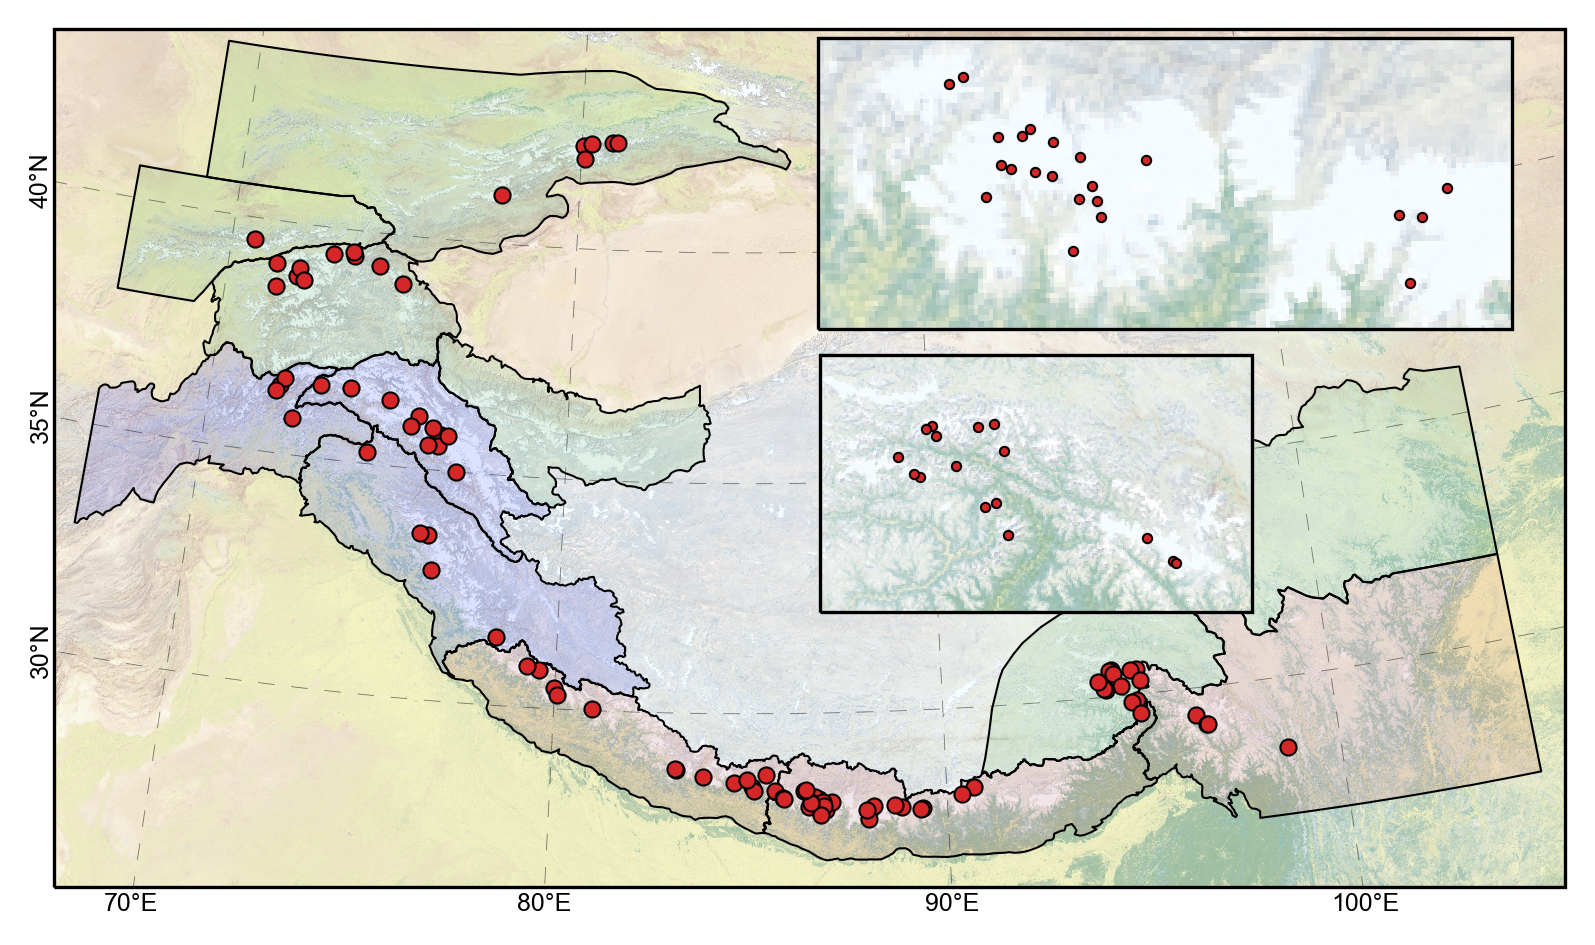

In [32]:
##### figure showing glaciers with increasing trend in SGL area over past 10 years

# initiate figure
fig,axs = plt.subplots(figsize=(6.5,4), dpi=300, subplot_kw={'projection':projection_shean})

# background image
background_im.plot.imshow(rgb='band', ax=axs, zorder=1)

# o2region boundaries, adding colors along the way
o2_gdf.plot(ax=axs, edgecolor='none', color=o2_gdf['colors'], alpha=0.1,
                    transform=projection_esri, zorder=3)
o2_gdf.boundary.plot(ax=axs, edgecolor='black', facecolor='none', linewidth=0.5,
                     transform=projection_esri, zorder=3)

# add glaciers with increasing trend in SGL area over past 10 years
df_to_use = rgi_id_ntgain_1423
rgi_plot = rgi_gdf[rgi_gdf['rgi_id'].isin(df_to_use['rgi_id'])]
gdf_points = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(rgi_plot['cenlon'],rgi_plot['cenlat']),crs="EPSG:4326").to_crs("ESRI:102025")
gdf_points.plot(ax=axs, color='tab:red', edgecolor='black', markersize=15, linewidth=0.5, alpha=1, zorder=4,
               transform=projection_esri)

# axis limits, etc
axs.set_xlim(xlims_main)
axs.set_ylim(ylims_main)
axs.set_title("", size=6)

# add lat/lon gridlines
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ypadding=3, xpadding=4,
              linestyle=(5,(20,20)), linewidth=0.2, color='0', alpha=0.5)

# gridline edits
gl.top_labels=False
gl.right_labels=False
gl.xlabel_style = {'size':6, 'rotation':'horizontal', 'ha':'center'}
gl.ylabel_style = {'size':6, 'rotation':'vertical', 'ha':'center'}
gl.xlocator = mticker.FixedLocator([70, 80, 90, 100])
gl.ylocator = mticker.FixedLocator([30, 35, 40])

### inset axis to zoom in on everest region
ax_ev = axs.inset_axes( (0.49, 0.65 , 0.49, 0.34), projection=projection_shean,
                      xlim=(92000,330000), ylim=(-950000,-850000))
background_im.plot.imshow(rgb='band', ax=ax_ev, zorder=1)
gdf_points.plot(ax=ax_ev, color='tab:red', edgecolor='black', markersize=5, linewidth=0.5, alpha=1, zorder=4,
               transform=projection_esri)
ax_ev.set_title("")


### inset axis to zoom in on eastern china/tibet region
ax_ec = axs.inset_axes( (0.5, 0.32, 0.3, 0.3), projection=projection_shean,
                      xlim=(780000,1200000), ylim=(-750000,-500000))
background_im.plot.imshow(rgb='band', ax=ax_ec, zorder=1)
gdf_points.plot(ax=ax_ec, color='tab:red', edgecolor='black', markersize=5, linewidth=0.5, alpha=1, zorder=4,
               transform=projection_esri)
ax_ec.set_title("")

Text(0.5, 1.0, '')

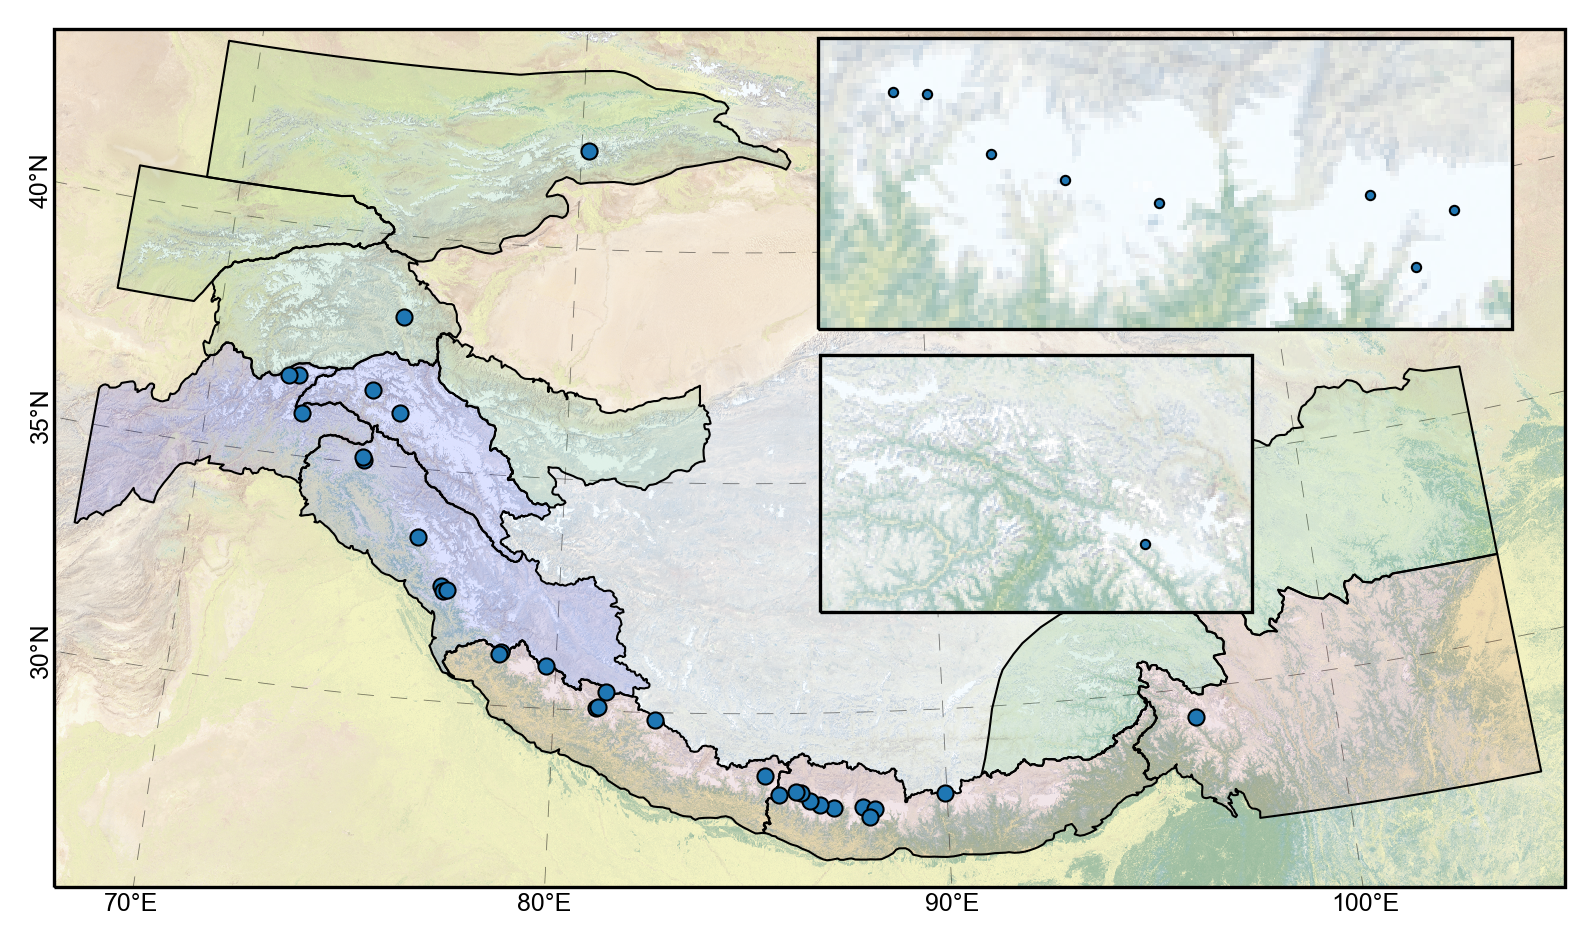

In [34]:
##### figure showing glaciers with decreasing trend in SGL area over past 10 years

# initiate figure
fig,axs = plt.subplots(figsize=(6.5,4), dpi=300, subplot_kw={'projection':projection_shean})

# background image
background_im.plot.imshow(rgb='band', ax=axs, zorder=1)

# o2region boundaries, adding colors along the way
o2_gdf.plot(ax=axs, edgecolor='none', color=o2_gdf['colors'], alpha=0.1,
                    transform=projection_esri, zorder=3)
o2_gdf.boundary.plot(ax=axs, edgecolor='black', facecolor='none', linewidth=0.5,
                     transform=projection_esri, zorder=3)

# add glaciers with increasing trend in SGL
df_to_use = rgi_id_ntloss_1423
rgi_plot = rgi_gdf[rgi_gdf['rgi_id'].isin(df_to_use['rgi_id'])]
gdf_points = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(rgi_plot['cenlon'],rgi_plot['cenlat']),crs="EPSG:4326").to_crs("ESRI:102025")
gdf_points.plot(ax=axs, color='tab:blue', edgecolor='black', markersize=15, linewidth=0.5, alpha=1, zorder=4,
               transform=projection_esri)

# axis limits, etc
axs.set_xlim(xlims_main)
axs.set_ylim(ylims_main)
axs.set_title("", size=6)

# add lat/lon gridlines
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ypadding=3, xpadding=4,
              linestyle=(5,(20,20)), linewidth=0.2, color='0', alpha=0.5)

# gridline edits
gl.top_labels=False
gl.right_labels=False
gl.xlabel_style = {'size':6, 'rotation':'horizontal', 'ha':'center'}
gl.ylabel_style = {'size':6, 'rotation':'vertical', 'ha':'center'}
gl.xlocator = mticker.FixedLocator([70, 80, 90, 100])
gl.ylocator = mticker.FixedLocator([30, 35, 40])

### inset axis to zoom in on everest region
ax_ev = axs.inset_axes( (0.49, 0.65 , 0.49, 0.34), projection=projection_shean,
                      xlim=(92000,330000), ylim=(-950000,-850000))
background_im.plot.imshow(rgb='band', ax=ax_ev, zorder=1)
gdf_points.plot(ax=ax_ev, color='tab:blue', edgecolor='black', markersize=5, linewidth=0.5, alpha=1, zorder=4,
               transform=projection_esri)
ax_ev.set_title("")


### inset axis to zoom in on eastern china/tibet region
ax_ec = axs.inset_axes( (0.5, 0.32, 0.3, 0.3), projection=projection_shean,
                      xlim=(780000,1200000), ylim=(-750000,-500000))
background_im.plot.imshow(rgb='band', ax=ax_ec, zorder=1)
gdf_points.plot(ax=ax_ec, color='tab:blue', edgecolor='black', markersize=5, linewidth=0.5, alpha=1, zorder=4,
               transform=projection_esri)
ax_ec.set_title("")